# Grammar Coverage

In this chapter, we explore how to systematically cover elements of a grammar.

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* You should have read the [chapter on efficient grammar fuzzing](GrammarFuzzer.ipynb).

## Covering Grammar Elements

[Producing inputs from grammars](GrammarFuzzer.ipynb) gives all possible expansions of a rule the same likelihood.  For producing a comprehensive test suite, however, it makes more sense to maximize _variety_ – for instance, by avoiding repeating the same expansions over and over again.  To achieve this, we can track the _coverage_ of individual expansions: If we have seen some expansion already, we can prefer other possible expansions in the future.

As an example, consider the grammar

```grammar
<start> ::= <digit><digit>
<digit> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
```

Let us assume we have already produced a `0` in the first expansion of `<digit>`.  As it comes to expand the next digit, we would mark the `0` expansion as already covered, and choose one of the yet uncovered alternatives.  Only when we have covered all alternatives would we go back and consider expansions covered before.

### Tracking Grammar Coverage

This concept of coverage is very easy to implement.  We introduce a class `GrammarCoverageFuzzer` that keeps track of the current grammar coverage achieved:

In [1]:
import fuzzingbook_utils

In [2]:
from Grammars import DIGIT_GRAMMAR, EXPR_GRAMMAR, CGI_GRAMMAR, URL_GRAMMAR, START_SYMBOL, is_valid_grammar

In [3]:
from GrammarFuzzer import GrammarFuzzer, all_terminals, nonterminals, display_tree

In [4]:
import random

In [5]:
class TrackingGrammarCoverageFuzzer(GrammarFuzzer):
    def __init__(self, *args, **kwargs):
        # invoke superclass __init__(), passing all arguments
        super().__init__(*args, **kwargs)
        self.reset_coverage()

    def reset_coverage(self):
        self.covered_expansions = set()

    def expansion_coverage(self):
        return self.covered_expansions

In this set `covered_expansions`, we store individual expansions seen as pairs of (_symbol_, _expansion_), using the method `expansion_key()` to generate a string representation for the pair.

In [6]:
class TrackingGrammarCoverageFuzzer(TrackingGrammarCoverageFuzzer):
    def expansion_key(self, symbol, expansion):
        """Convert (symbol, children) into a key.  `children` can be an expansion string or a derivation tree."""
        if not isinstance(expansion, str):
            children = expansion
            expansion = all_terminals((symbol, children))
        return symbol + " -> " + expansion

In [7]:
f = TrackingGrammarCoverageFuzzer(EXPR_GRAMMAR)
f.expansion_key(START_SYMBOL, EXPR_GRAMMAR[START_SYMBOL][0])

'<start> -> <expr>'

Instead of _expansion_, we can also pass a list of children as argument, which will then automatically be converted into a string.

In [8]:
children = [("<expr>", None), (" + ", []), ("<term>", None)]
f.expansion_key("<expr>", children)

'<expr> -> <expr> + <term>'

We can compute the set of possible expansions in a grammar by enumerating all expansions:

In [9]:
class TrackingGrammarCoverageFuzzer(TrackingGrammarCoverageFuzzer):
    def max_expansion_coverage(self):
        """Return set of all expansions in a grammar"""
        expansions = set()
        for nonterminal in self.grammar:
            for expansion in self.grammar[nonterminal]:
                expansions.add(self.expansion_key(nonterminal, expansion))
        return expansions

In [10]:
f = TrackingGrammarCoverageFuzzer(DIGIT_GRAMMAR)
f.max_expansion_coverage()

{'<start> -> 0',
 '<start> -> 1',
 '<start> -> 2',
 '<start> -> 3',
 '<start> -> 4',
 '<start> -> 5',
 '<start> -> 6',
 '<start> -> 7',
 '<start> -> 8',
 '<start> -> 9'}

During expansion, we can keep track of expansions seen.  To do so, we hook into the method `choose_node_expansion()`, expanding a single node in our [Grammar fuzzer](GrammarFuzzer.ipynb).

In [11]:
class TrackingGrammarCoverageFuzzer(TrackingGrammarCoverageFuzzer):
    def add_coverage(self, symbol, new_children):
        key = self.expansion_key(symbol, new_children)

        if self.log and key not in self.covered_expansions:
            print("Now covered:", key)
        self.covered_expansions.add(key)

    def choose_node_expansion(self, node, possible_children):
        (symbol, children) = node
        index = super().choose_node_expansion(node, possible_children)
        self.add_coverage(symbol, possible_children[index])
        return index

With this, we can now systematically check which expansions already have been covered – and which ones still have to be covered.

In [12]:
f = TrackingGrammarCoverageFuzzer(DIGIT_GRAMMAR, log=True)
f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 9
Tree: 9
'9'


'9'

In [13]:
f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 0
Tree: 0
'0'


'0'

In [14]:
f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 5
Tree: 5
'5'


'5'

Here's the set of covered expansions so far:

In [15]:
f.expansion_coverage()

{'<start> -> 0', '<start> -> 5', '<start> -> 9'}

On average, how many characters do we have to produce until all expansions are covered?

In [16]:
def average_length_until_full_coverage(fuzzer):
    trials = 50

    sum = 0
    for trial in range(trials):
        fuzzer.reset_coverage()
        while len(fuzzer.max_expansion_coverage() -
                  fuzzer.expansion_coverage()) > 0:
            s = fuzzer.fuzz()
            sum += len(s)

    return sum / trials

In [17]:
average_length_until_full_coverage(TrackingGrammarCoverageFuzzer(EXPR_GRAMMAR))

134.94

### Covering Grammar Expansions

Let us now not only track coverage, but actually _produce_ coverage.  The idea is as follows:

1. We determine children yet uncovered (in `uncovered_children`)
2. If all children are covered, we fall back to the original method (i.e., choosing one expansion randomly)
3. Otherwise, we select a child from the uncovered children and mark it as covered.

To this end, we introduce a new fuzzer `SimpleGrammarCoverageFuzzer` that implements this strategy in the `choose_node_expansion()` method.

In [18]:
class SimpleGrammarCoverageFuzzer(TrackingGrammarCoverageFuzzer):
    def choose_node_expansion(self, node, possible_children):
        # Prefer uncovered expansions
        (symbol, children) = node
        uncovered_children = [(i, c) for (i, c) in enumerate(possible_children)
                              if self.expansion_key(symbol, c) not in self.covered_expansions]

        if len(uncovered_children) == 0:
            # All expansions covered - use superclass method
            if self.log:
                print("All", symbol, "alternatives covered")
            return super().choose_node_expansion(node, possible_children)

        # select a random expansion
        index = random.randrange(len(uncovered_children))
        (new_children_index, new_children) = uncovered_children[index]

        # Save the expansion as covered
        self.add_coverage(symbol, new_children)

        return new_children_index

By returning the set of expansions covered so far, we can invoke the fuzzer multiple times, each time adding to the grammar coverage.  With the `DIGIT_GRAMMAR` grammar, for instance, this lets the grammar produce one digit after the other:

In [19]:
f = SimpleGrammarCoverageFuzzer(DIGIT_GRAMMAR, log=True)
f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 7
Tree: 7
'7'


'7'

In [20]:
f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 9
Tree: 9
'9'


'9'

In [21]:
f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 2
Tree: 2
'2'


'2'

Here's the set of covered expansions so far:

In [22]:
f.expansion_coverage()

{'<start> -> 2', '<start> -> 7', '<start> -> 9'}

Let us fuzz some more. We see that with each iteration, we cover another expansion:

In [23]:
for i in range(7):
    f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 8
Tree: 8
'8'
Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 6
Tree: 6
'6'
Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 1
Tree: 1
'1'
Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 0
Tree: 0
'0'
Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 5
Tree: 5
'5'
Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 3
Tree: 3
'3'
Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 4
Tree: 4
'4'


At the end, all expansions are covered:

In [24]:
f.max_expansion_coverage() - f.expansion_coverage()

set()

Let us apply this on a more complex grammar – e.g., the expression grammar.  We see that after a few iterations, we cover each and every digit, operator, and expansion:

In [25]:
f = SimpleGrammarCoverageFuzzer(EXPR_GRAMMAR)
for i in range(10):
    print(f.fuzz())

54823 * 7.90687 / -(+01 / (8 / 6 + 6) * 2.0 - 8 / 7 + 1 * 4 + 7)
+4.0 * 86 + (2 - 0 * 9) * --3 * 0 + (6 / 7 - 5) / 5 + 1
(-(1 - 5) - 6 * 9 - 4 / 1 + 2) / (2) / -2.0
(66.4 * 1 * 1 * 7 * 1 - 2 * 9 / 4) * 3
-+-7.0561487035906
+(-4 / 8 + 9 - 8) - -(4 - 0) + 3 * 2 + 1 + 8
+3.9
7500 * 6.45
(7 - 0) / 0 + (4 + 7) / 9 / 9 * 6 / 5 / 0
++(63.441) / -(5 + ++-3 * 5) / 06 / 48.16 / 39 / 1


Again, all expansions are covered:

In [26]:
f.max_expansion_coverage() - f.expansion_coverage()

set()

We see that our strategy is much more effective than random in achieving coverage:

In [27]:
average_length_until_full_coverage(SimpleGrammarCoverageFuzzer(EXPR_GRAMMAR))

59.46

## Deep Foresight

Selecting expansions for individual rules is a good start; however, it is not sufficient, as the following example shows.  We apply our coverage fuzzer on the CGI grammar:

In [28]:
f = SimpleGrammarCoverageFuzzer(CGI_GRAMMAR)

In [29]:
for i in range(10):
    print(f.fuzz())

%3e+
c
%9a+
_
%d7
+%16
%b50-
d
%041
43


After 10 iterations, we still have a number of expansions uncovered:

In [30]:
f.max_expansion_coverage() - f.expansion_coverage()

{'<hexdigit> -> 2',
 '<hexdigit> -> 8',
 '<hexdigit> -> c',
 '<hexdigit> -> f',
 '<other> -> 2',
 '<other> -> 5',
 '<other> -> a',
 '<other> -> b',
 '<other> -> e'}

Why is that so?  The problem is that in the CGI grammar, the largest number of variations to be covered occurs in the `hexdigit` rule.  However, we first need to _reach_ this expansion.  When expanding a `<letter>` symbol, we have the choice between three possible expansions:

In [31]:
CGI_GRAMMAR["<letter>"]

['<plus>', '<percent>', '<other>']

If all three expansions are covered already, then `choose_node_expansion()` above will choose one randomly – even if there may be more expansions to cover when choosing `<percent>`.

What we need is a better strategy that will pick `<percent>` if there are more uncovered expansions following – even if `<percent>` is covered.  Such a strategy was first discussed by W. Burkhardt \cite{Burkhardt1967} under the name of "Shortest Path Selection":

> This version selects, from several alternatives for development, that syntactic unit under which there is still an unused unit available, starting with the shortest path.
    
This is what we will implement in the next steps.

### Determining Maximum per-Symbol Coverage

To address this problem, we introduce a new class `GrammarCoverageFuzzer` that builds on `SimpleGrammarCoverageFuzzer`, but with a better strategy.  First, we need to compute the _maximum set of expansions_ that can be reached from a particular symbol. The idea is to later compute the _intersection_ of this set and the expansions already covered, such that we can favor those expansions with a non-empty intersection.

Our method `max_symbol_expansion_coverage()` computes this maximum set of expansions.  The helper method `_max_symbol_expansion_coverage()` does the heavy lifting, iterating through the grammar up to a given depth and tracking which symbols (`symbols_seen`) and which coverage (`cov`) has already been seen:

In [32]:
class GrammarCoverageFuzzer(TrackingGrammarCoverageFuzzer):
    def _max_symbol_expansion_coverage(
            self, symbol, max_depth, cov, symbols_seen):
        """Return set of all expansions in a grammar starting with `symbol`"""
        if max_depth <= 0:
            return (cov, symbols_seen)

        symbols_seen.add(symbol)
        for expansion in self.grammar[symbol]:
            key = self.expansion_key(symbol, expansion)
            if key in cov:
                continue

            cov.add(key)
            for s in nonterminals(expansion):
                if s in symbols_seen:
                    continue
                new_cov, new_symbols_seen = (
                    self._max_symbol_expansion_coverage(s, max_depth - 1, cov, symbols_seen))
                cov |= new_cov
                symbols_seen |= new_symbols_seen

        return (cov, symbols_seen)

The main method `max_symbol_expansion_coverage()` simply returns the coverage that can be achieved:

In [33]:
class GrammarCoverageFuzzer(GrammarCoverageFuzzer):
    def max_symbol_expansion_coverage(self, symbol, max_depth=float('inf')):
        cov, symbols_seen = self._max_symbol_expansion_coverage(
            symbol, max_depth, set(), set())
        return cov

With this, we can compute the possible expansions for every symbol

In [34]:
f = GrammarCoverageFuzzer(EXPR_GRAMMAR)
f.max_symbol_expansion_coverage('<integer>')

{'<digit> -> 0',
 '<digit> -> 1',
 '<digit> -> 2',
 '<digit> -> 3',
 '<digit> -> 4',
 '<digit> -> 5',
 '<digit> -> 6',
 '<digit> -> 7',
 '<digit> -> 8',
 '<digit> -> 9',
 '<integer> -> <digit>',
 '<integer> -> <digit><integer>'}

In [35]:
f.max_symbol_expansion_coverage('<digit>')

{'<digit> -> 0',
 '<digit> -> 1',
 '<digit> -> 2',
 '<digit> -> 3',
 '<digit> -> 4',
 '<digit> -> 5',
 '<digit> -> 6',
 '<digit> -> 7',
 '<digit> -> 8',
 '<digit> -> 9'}

The maximum coverage achievable in a grammar is the same as starting with the start symbol:

In [36]:
assert f.max_expansion_coverage() == f.max_symbol_expansion_coverage(START_SYMBOL)

### Determining Children with new Coverage

The definition of `max_symbol_expansion_coverage()` allows us to determine the _new_ coverage for each child.  To this end, we _subtract_ the coverage already seen (`expansion_coverage()`) from the coverage that could be obtained.

In [37]:
class GrammarCoverageFuzzer(GrammarCoverageFuzzer):
    def _new_child_coverage(self, children, max_depth):
        new_cov = set()
        for (c_symbol, _) in children:
            if c_symbol in self.grammar:
                new_cov |= self.max_symbol_expansion_coverage(
                    c_symbol, max_depth)
        return new_cov

    def new_child_coverage(self, symbol, children, max_depth=float('inf')):
        """Return new coverage that would be obtained by expanding (symbol, children)"""
        new_cov = self._new_child_coverage(children, max_depth)
        for c in children:
            new_cov.add(self.expansion_key(symbol, children))
        new_cov -= self.expansion_coverage()   # set subtraction
        return new_cov

Let us illustrate `new_child_coverage()`.  We again start fuzzing, choosing expansions randomly.

In [38]:
f = GrammarCoverageFuzzer(DIGIT_GRAMMAR, log=True)
f.fuzz()

Tree: <start>
Expanding <start> randomly
Now covered: <start> -> 5
Tree: 5
'5'


'5'

This is our current coverage:

In [39]:
f.expansion_coverage()

{'<start> -> 5'}

When we go through the individual expansion possibilities for `START_SYMBOL`, we see that all expansions offer additional coverage, _except_ for the one we have just seen.

In [40]:
for expansion in DIGIT_GRAMMAR[START_SYMBOL]:
    children = f.expansion_to_children(expansion)
    print(expansion, f.new_child_coverage(START_SYMBOL, children))

0 {'<start> -> 0'}
1 {'<start> -> 1'}
2 {'<start> -> 2'}
3 {'<start> -> 3'}
4 {'<start> -> 4'}
5 set()
6 {'<start> -> 6'}
7 {'<start> -> 7'}
8 {'<start> -> 8'}
9 {'<start> -> 9'}


This means that whenever choosing an expansion, we can make use of `new_child_coverage()` and choose among the expansions that offer the greatest new (unseen) coverage.

### Adaptive Lookahead

When choosing a child, we do not look out for the maximum overall coverage to be obtained, as this would result in expansions with many uncovered possibilities totally dominate other expansions.  Instead, we aim for a _breadth-first_ strategy, first covering all expansions up to a given depth, and only then looking for a greater depth.  The method `new_coverages()` is at the heart of this strategy: Starting with a maximum depth (`max_depth`) of zero, it increases the depth until it finds at least one uncovered expansion.

In [41]:
class GrammarCoverageFuzzer(GrammarCoverageFuzzer):
    def new_coverages(self, node, possible_children):
        """Return coverage to be obtained for each child at minimum depth"""
        (symbol, children) = node
        for max_depth in range(len(self.grammar)):
            new_coverages = [
                self.new_child_coverage(
                    symbol, c, max_depth) for c in possible_children]
            max_new_coverage = max(len(new_coverage)
                                   for new_coverage in new_coverages)
            if max_new_coverage > 0:
                # Uncovered node found
                return new_coverages

        # All covered
        return None

### All Together

We can now define `choose_node_expansion()` to make use of this strategy: First, we determine the possible coverages to be obtained (using `new_coverages()`); then we (randomly) select among the children which sport the maximum coverage.

In [42]:
class GrammarCoverageFuzzer(GrammarCoverageFuzzer):
    def choose_node_expansion(self, node, possible_children):
        (symbol, children) = node
        new_coverages = self.new_coverages(node, possible_children)

        if new_coverages is None:
            # All expansions covered - use superclass method
            return GrammarFuzzer.choose_node_expansion(
                self, node, possible_children)

        max_new_coverage = max(len(cov) for cov in new_coverages)
        children_with_max_new_coverage = [(i, c) for (i, c) in enumerate(possible_children)
                                          if len(new_coverages[i]) == max_new_coverage]

        # select a random expansion
        new_children_index, new_children = random.choice(
            children_with_max_new_coverage)

        # Save the expansion as covered
        key = self.expansion_key(symbol, new_children)

        if self.log:
            print("Now covered:", key)
        self.covered_expansions.add(key)

        return new_children_index

Our fuzzer is now complete.  Let us apply it on a series of examples.  On expressions, it quickly covers all digits and operators:

In [43]:
f = GrammarCoverageFuzzer(EXPR_GRAMMAR, min_nonterminals=3)
f.fuzz()

'0192.4 * (5 + 4) / 3 - +7 + 6 * 8'

In [44]:
f.max_expansion_coverage() - f.expansion_coverage()

{'<factor> -> -<factor>'}

On average, it is again faster than the simple strategy:

In [45]:
average_length_until_full_coverage(GrammarCoverageFuzzer(EXPR_GRAMMAR))

50.64

On the CGI grammar, it takes but a few iterations to cover all letters and digits:

In [46]:
f = GrammarCoverageFuzzer(CGI_GRAMMAR, min_nonterminals=5)
while len(f.max_expansion_coverage() - f.expansion_coverage()) > 0:
    print(f.fuzz())

%45%7e%62a+20
c5%f1b4e_3d-1
%bc%9a%08%d3%e9


This improvement can also be seen in comparing the random, expansion-only, and deep foresight strategies on the CGI grammar:

In [47]:
average_length_until_full_coverage(TrackingGrammarCoverageFuzzer(CGI_GRAMMAR))

213.1

In [48]:
average_length_until_full_coverage(SimpleGrammarCoverageFuzzer(CGI_GRAMMAR))

68.64

In [49]:
average_length_until_full_coverage(GrammarCoverageFuzzer(CGI_GRAMMAR))

40.38

## Code Coverage via Grammar Coverage

By systematically covering all input elements, we get a larger variety in inputs – but does this translate into a wider variety of program behaviors?  After all, these behaviors are what we want to cover, including the unexpected behaviors. 

In a grammar, there are elements that directly correspond to program features.  A program handling arithmetic expressions will have functionality that is directly triggered by individual elements - say, an addition feature triggered by the presence of `+`, subtraction triggered by the presence of `-`, and floating-point arithmetic triggered by the presence of floating-point numbers in the input.

Such a connection between input structure and functionality leads to a strong _correlation between grammar coverage and code coverage_.  In other words: If we can achieve a high grammar coverage, this also leads to a high code coverage.

### CGI Grammars

Let us explore this relationship on one of our grammars – say, the CGI decoder.  We compute a mapping `coverages` where in `coverages[x]` = `{y_1, y_2, ...}`, `x` is the grammar coverage obtained, and `y_n` is the code coverage obtained for the `n`-th run:

In [50]:
from Coverage import Coverage, cgi_decode

In [51]:
f = GrammarCoverageFuzzer(CGI_GRAMMAR, max_nonterminals=2)
coverages = {}

trials = 100
for trial in range(trials):
    f.reset_coverage()
    overall_cov = set()

    for i in range(10):
        s = f.fuzz()
        with Coverage() as cov:
            cgi_decode(s)
        overall_cov |= cov.coverage()

        x = len(f.expansion_coverage())
        y = len(overall_cov)
        if x not in coverages:
            coverages[x] = []
        coverages[x].append(y)

We compute the averages for the `y`-values:

In [52]:
xs = list(coverages.keys())
ys = [sum(coverages[x]) / len(coverages[x]) for x in coverages]

and create a scatter plot:

In [53]:
%matplotlib inline

In [54]:
import matplotlib.pyplot as plt

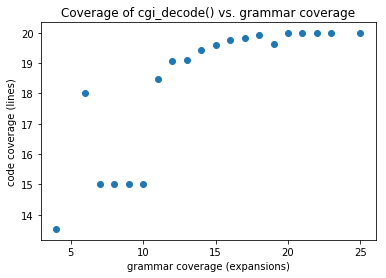

In [55]:
plt.scatter(xs, ys)
plt.title('Coverage of cgi_decode() vs. grammar coverage')
plt.xlabel('grammar coverage (expansions)')
plt.ylabel('code coverage (lines)');

We see that the higher the grammar coverage, the higher the code coverage.  This also translates into a correlation coefficient of about 0.8, indicating a strong correlation:

In [56]:
import numpy as np

In [57]:
np.corrcoef(xs, ys)

array([[1.        , 0.82160042],
       [0.82160042, 1.        ]])

### URL Grammars

Let us repeat this experiment on URL grammars.  We use the same code as above, except for exchanging the grammars and the function in place:

In [58]:
try:
    from urlparse import urlparse      # Python 2
except ImportError:
    from urllib.parse import urlparse  # Python 3

In [59]:
f = GrammarCoverageFuzzer(URL_GRAMMAR, max_nonterminals=2)
coverages = {}

trials = 100
for trial in range(trials):
    f.reset_coverage()
    overall_cov = set()

    for i in range(20):
        s = f.fuzz()
        with Coverage() as cov:
            urlparse(s)
        overall_cov |= cov.coverage()

        x = len(f.expansion_coverage())
        y = len(overall_cov)
        if x not in coverages:
            coverages[x] = []
        coverages[x].append(y)

In [60]:
xs = list(coverages.keys())
ys = [sum(coverages[x]) / len(coverages[x]) for x in coverages]

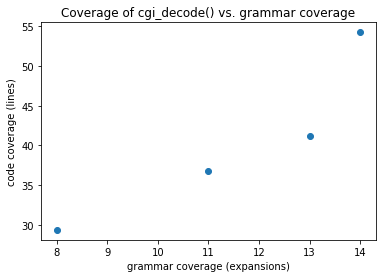

In [61]:
plt.scatter(xs, ys)
plt.title('Coverage of cgi_decode() vs. grammar coverage')
plt.xlabel('grammar coverage (expansions)')
plt.ylabel('code coverage (lines)');

Here, we have an even stronger correlation of almost .95:

In [62]:
np.corrcoef(xs, ys)

array([[1.        , 0.92004127],
       [0.92004127, 1.        ]])

We conclude: If one wants to obtain high code coverage, it is a good idea to strive for high grammar coverage first.

### Will this always work?

The correlation observed for the CGI and URL examples will not hold for every program and every structure.

#### Equivalent Elements

First, some grammar elements are treated uniformly by a program even though the grammar sees them as different symbols.  In the host name of a URL, for instance, we can have many different characters, although a URL-handling program treats them all the same.  Likewise, individual digits, once composed into a number, make less of a difference than the value of the number itself.  Hence, achieving variety in digits or characters will not yield a large difference in functionality.

#### Deep Data Processing

Second, the way the data is processed can make a large difference.  Consider the input to a _media player_, consisting of compressed media data.  While processing the media data, the media player will show differences in behavior (notably in its output), but these differences cannot be directly triggered through individual elements of the media data.  Likewise, a _machine learner_ that is trained on a large set of inputs typically will not have its behavior controlled by a single syntactic element of the input.  (Well, it could, but then, we would not need a machine learner.)

In these cases of "deep" data processing, achieving coverage in the grammar will not necessarily induce code coverage.  We still can make use of the grammar to produce _valid_ inputs, but will have to rely on chance and patience to cover functionality and trigger bugs.  _Some_ parts of the input, though, can still be covered: _Metadata_ (such as author name or composer for the media player) or _configuration data_ (such as settings for the machine learner) can and should be covered systematically; we will see how this is done [in the chapter on "Configuration fuzzing"](ConfigurationFuzzer.ipynb).

## Lessons Learned

* Achieving _grammar coverage_ quickly results in a large variety of inputs.
* Achieving grammar coverage can help in obtaining _code coverage_.

## Next Steps

From here, you can learn how to

* [use grammar coverage to systematically test cpnfigurations](ConfigurationFuzzer.ipynb)


## Background

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}. \todo{Add more.}

## Exercises


### Exercise 1: Testing ls

Consider the Unix `ls` program, used to list the contents of a directory.  Create a grammar for invoking `ls`:

In [63]:
LS_EBNF_GRAMMAR = {
    '<start>': ['-<options>'],
    '<options>': ['<option>*'],
    '<option>': ['1', 'A', '@',
                 # many more
                 ]
}

assert is_valid_grammar(LS_EBNF_GRAMMAR)

Use `GrammarCoverageFuzzer` to test all options.  Be sure to invoke `ls` with each option set.

**Solution.**  We can copy the set of option characters right from the manual page:

In [64]:
from Grammars import convert_ebnf_grammar, srange

In [65]:
LS_EBNF_GRAMMAR = {
    '<start>': ['-<options>'],
    '<options>': ['<option>*'],
    '<option>': srange("ABCFGHLOPRSTUW@abcdefghiklmnopqrstuwx1")
}
assert is_valid_grammar(LS_EBNF_GRAMMAR)

In [66]:
LS_GRAMMAR = convert_ebnf_grammar(LS_EBNF_GRAMMAR)

In [67]:
from Fuzzer import ProgramRunner

In [68]:
f = GrammarCoverageFuzzer(LS_GRAMMAR, max_nonterminals=3)
while len(f.max_expansion_coverage() - f.expansion_coverage()) > 0:
    invocation = f.fuzz()
    print("ls", invocation, end="; ")
    args = invocation.split()
    ls = ProgramRunner(["ls"] + args)
    ls.run()
print()

ls -k; ls -bP; ls -GR; ls -xa; ls -hs; ls -@Lo; ls -ScTi; ls -Ue; ls -qlW; ls -gBtHC; ls -umpnA; ls -drO; ls -f1; ls -wdF; 


By setting `max_nonterminals` to other values, you can control how many options `ls` should be invoked with.

### Exercise 2: Caching

The value of `max_symbol_expansion_coverage()` depends on the grammar only.  Change the implementation such that the values are precomputed for each symbol upon initialization (`__init__()`); this way, `max_symbol_expansion_coverage()` can simply lookup the value in the table.

**Solution.** This is like exercise 1 and 2 [in the chapter on efficient grammar fuzzing](GrammarFuzzer.ipynb); you can implement a similar solution here.